## AC 209B: Homework 5
### Neural Net Basics & Feed-forward Nets
** Harvard University ** <br>
** Spring  2018 ** <br>
** Instructors:** Pavlos Protopapas and Mark Glickman 

---

### INSTRUCTIONS

- To submit your assignment follow the instructions given in canvas. Make sure you include:
 1. This notebook file `ac209b_HW5.ipynb`.
 2. `cs209b/softmax.py`
 3. `cs209b/neural_net.py`
 4. `cs209b/optim.py`
- Restart the kernel and run the whole notebook again before you submit. 
- Do not include your name(s) in the notebook if you are submitting as a group. 
- If you submit individually and you have worked with someone, please include the name of your [one] partner below. 

---

** Your partner's name (if you submit separately): **

___
### Download CIFAR-10

In these exercises you will implement some basic feedforward networks with numpy. You will not use Tensorflow or Keras in the following. See the `requirements.txt` to set up your environment. This is necessary for reproducibility reasons. Once you have set-up the working environment, download the CIFAR-10 dataset:
```bash
cd datasets/
./get_datasets.sh
```

Note: if the script does not work for you, simply got to http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz and download the file. 

---

## Part 1: Softmax exercise (5pt)

In this exercise you will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**

Run the following code to load libraries and CIFAR-10 database.

In [1]:
import random
import numpy as np
from cs209b.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [161]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = '../datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    # Validation set
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    # Training set
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    # Test set
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    # Dev data set: just for debugging purposes, it overlaps with the training set,
    # but has a smaller size.
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()

# Training parameters
m_train = X_train.shape[0]   # number of training examples
m_dev = X_dev.shape[0]       # number of training examples in the development set
n = X_train.shape[1]         # features dimension
c = 10                       # number of classes in the database

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3072)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3072)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3072)
Test labels shape:  (1000,)
dev data shape:  (500, 3072)
dev labels shape:  (500,)


The following function converts the class labels into a one hot encoding representation. 
The output of the encoding is $(m,c)$, where $m$ corresponds to the number of examples and $c$ to the number of categories.

In [162]:
from sklearn.preprocessing import OneHotEncoder
def encode_labels(y):
    enc = OneHotEncoder()
    enc.fit(y.reshape(-1,1))
    y_enc = enc.transform(y.reshape(-1,1)).toarray()
    return y_enc

Y_train_enc = encode_labels(y_train)
Y_val_enc =  encode_labels(y_val)
Y_dev_enc = encode_labels(y_dev)
Y_test_enc = encode_labels(y_test)

### Softmax function
Your code for this part should all be written inside **cs209b/softmax.py**.

The expression of the multiclass cross-entropy plus regularization is given by:
\begin{equation}
    J(W, b, X,y, \text{reg}) = 
    - \frac{1}{m}\sum_{i=1}^m \sum_{j=1}^c y_j^{(i)} \log \Bigg( \frac{e^{w_j x^{(i)}+b_j}}{\sum_{r=1}^c e^{w_r x^{(i)} + b_r}} \Bigg) 
    + \frac{1}{2}\text{reg} \Vert W\Vert^2.
\end{equation}
Note that we do not regularize the bias term.

Other variables of interest take the following dimensions: 
- $c$ is the total number of classes; $m$ the number of examples or the size of the mini-batch; $n$ is the dimension of the input.
- $W$ is matrix of size $(c,n)$; $w_j$ refers to the $j$th row, has size $(1,n)$.
- $b$ is a column vector, with size $(c,1)$; $b_j$ is the $j$th component. 
- $X$ is the training mini-batch, with size $(m,n)$; $x^{(i)}$ is the $i$th example.
- $Y$ has the labeling data with a one-hot encoding representation, and has size $(m,c)$; $y^{(i)}$ is the one-hot encoding for training example $i$, with size $(1,c)$.

### Forward pass:

1. Implement the  function `softmax_loss_naive`, which returns the loss of the cross-entropy function. Do not implement the gradient propagation just yet, we will explain that part after this exercise is completed and you have verified that it works correctly.
We recommend that you write this function using a for loop over the minibatch examples, and later make a vectorized version in `softmax_loss_vectorized`. However, if you want to program the vectorized version directly, feel free to have the same code in both functions.

2. Our loss should be something close to -log(0.1) (run the code below as a sanity check). Why do we expect our loss to be close to -log(0.1)? Explain briefly.



Do not forget the regularization term.

__Hints__: Avoid numerical problems by normalizing the exponents of the softmax function.

In [357]:
import paulnet.nn as nn
import paulnet.layers as layers
import paulnet.loss as ls 
import paulnet.optim as optim 
import paulnet.utils as util

In [273]:
from cs209b.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(c,n) * 0.0001
b = np.random.randn(c,1) * 0.0001
loss = softmax_loss_naive(W, b, X_dev, Y_dev_enc, reg = 0.0)[0]

# Test my framework
layer_lin = layers.Linear(n,c, init_vals=(W.T,b.ravel()))
loss_func = ls.CrossEntropy()
net = nn.Network([layer_lin], loss_func, optimizer=None)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('paulnet loss:', net.loss(X_dev, Y_dev_enc))
print('random loss:  %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

paulnet loss: 2.33454681161
random loss:  2.334547
sanity check: 2.302585



### Answer:

We expect the loss to be $-log(0.1))$ because we are making a totally random matrix of initial weights and we have $10$ total possible classes. This means $softmax$ will approximate (on the first forward pass) a random uniform on the output probabilities, which would be $0.1$ per item for the $10$ items. Then we take the log and negate as part of the output of our softmax loss.

### Backward pass:

Now we are going to program the gradient computation for the softmax function. You will have to figure out the correct expressions and make use of the chain rule. 

1. Finish the implementation of the function `softmax_loss_naive` returning correct gradients dW and db. These terms should have the following shapes:
    - dW has dimension $(c, n)$.
    - db has dimension $(c, 1)$.

   We provide the following derivative to help with your code:
   \begin{equation*}
       \frac{\partial J}{\partial z_j^{(i)}} = a_j^{(i)}-y_j^{(i)}
   \end{equation*}
   where $z_j^{(i)}=w_j x^{(i)}+b_j$ and $a_j^{(i)} = \frac{e^{z_j^{(i)}}}{\sum_{r=1}^c z_r^{(i)}}$.

2. Please, finish the implementation of `softmax_loss_naive` using loops. We will later implement the vectorized version, but feel free to do it now if that is your preference. Run the following code to check analytical gradients with numerical ones. You should get errors below $10^{-7}$ (except on the bias, which may be around $10^{-7}$).

### Gradient derivation:

For a minibatch $i$ with $z_j^{(i)}=w_j x^{(i)}+b_j$ and $p_j^{(i)} = \frac{e^{z_j^{(i)}}}{\sum_{r=1}^c e^{z_r^{(i)}}}$:

$J(W, b, X,y, \text{reg}) = 
    -\sum_{j=1}^c y_j^{(i)} \log \Bigg( \frac{e^{w_j x^{(i)}+b_j}}{\sum_{r=1}^c e^{w_r x^{(i)} + b_r}} \Bigg) 
    + \frac{1}{2}\text{reg} \Vert W\Vert^2$  

We can use the chain rule to compute the gradient w.r.t the weights and the bias with the expressions $\frac{\partial J}{\partial w_j^{(i)}} =\frac{\partial J}{\partial z_j^{(i)}}\frac{\partial z_j^{(i)}}{\partial w_j^{(i)}}$ and $\frac{\partial J}{\partial b_j^{(i)}} =\frac{\partial J}{\partial z_j^{(i)}}\frac{\partial z_j^{(i)}}{\partial b_j^{(i)}}$

Consider two cases.  In the first case we look at $\frac{\partial p_j^{(i)}}{\partial z_j^{(i)}}$.
$$\frac{\partial p_j^{(i)}}{\partial z_j^{(i)}} = \frac{e^{z_j}(\sum_{r=1}^c e^{z_r})-e^{z_j}(e^{z_j})}{(\sum_{r=1}^c e^{z_r})^2} = p_j^{(i)}(1-p_j^{(i)})$$

In the second case we look at $\frac{\partial p_j^{(i)}}{\partial z_k^{(i)}}$ for some $k$ s.t. $k \ne j$
$$\frac{\partial p_j^{(i)}}{\partial z_k^{(i)}} = \frac{0(\sum_{r=1}^c e^{z_r})-e^{z_j}(e^{z_k})}{(\sum_{r=1}^c e^{z_r})^2} = -\frac{e^{z_j}(e^{z_k})}{(\sum_{r=1}^c e^{z_r})^2} = -p_j^{(i)}p_k^{(i)}$$


Then we can find $\frac{\partial J}{\partial z_j^{(i)}}$ as follows, and the final step is valid because $y_k^{(i)}$ is a one hot vector:


\begin{align}
        \frac{\partial J}{\partial z_j^{(i)}} &= -\sum_{k=1}^c y_k^{(i)}\frac{1}{p_k^{(i)}}\frac{\partial p_k^{(i)}}{\partial z_j^{(i)}} \\
        &=-y_j^{(i)}(1-p_j^{(i)})-\sum_{k\ne i}^c y_k^{(i)}\frac{1}{p_k^{(i)}}(-p_j^{(i)}p_k^{(i)}) \\
        &= y_j^{(i)}p_j^{(i)}-y_j^{(i)}+\sum_{k\ne i}^c y_k^{(i)}p_j^{(i)}\\
        &= \sum_{k=1}^c y_k^{(i)}p_j^{(i)}-y_j^{(i)}\\
        &= p_j^{(i)}-y_j^{(i)}
\end{align}


Next, we need to find our partials w.r.t $w_j^{(i)}$ and $b_j^{(i)}$

$$\frac{\partial z_j^{(i)}}{\partial w_j^{(i)}} = x^{(i)}, \ \ \frac{\partial z_j^{(i)}}{\partial b_j^{(i)}} = 1$$


Thus, finally:

$$\frac{\partial J}{\partial w_j^{(i)}} =\frac{\partial J}{\partial z_j^{(i)}}\frac{\partial z_j^{(i)}}{\partial w_j^{(i)}} =  x^{(i)}(p_j^{(i)}-y_j^{(i)})$$

$$\frac{\partial J}{\partial b_j^{(i)}} =\frac{\partial J}{\partial z_j^{(i)}}\frac{\partial z_j^{(i)}}{\partial b_j^{(i)}} = p_j^{(i)}-y_j^{(i)}$$

In [4]:
from random import randrange
tuple([randrange(m) for m in (10,)])


(9,)

In [293]:
np.random.seed(1)
W = np.random.randn(c,n) * 0.0001
b = np.random.randn(c,1) * 0.0001
loss, grads = softmax_loss_naive(W, b, X_dev, Y_dev_enc, 0.0)
dW, db = grads["dW"], grads["db"]

# We use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs209b.gradient_check import grad_check_sparse
f = lambda W: softmax_loss_naive(W, b, X_dev, Y_dev_enc, 0.0)[0]
print("Numerical gradient of W without regularization:")
grad_numerical = grad_check_sparse(f, W, dW, 10)

# do another gradient check with regularization
loss, grads = softmax_loss_naive(W, b, X_dev, Y_dev_enc, 5e1)
dW, db = grads["dW"], grads["db"]
f = lambda W: softmax_loss_naive(W, b, X_dev, Y_dev_enc, 5e1)[0]
print("\nNumerical gradient of W with regularization:")
grad_numerical = grad_check_sparse(f, W, dW, 10)

# Verify gradient of bias:
from cs209b.gradient_check import grad_check_sparse
f = lambda b: softmax_loss_naive(W, b, X_dev, Y_dev_enc, 0.0)[0]
print("\nNumerical gradient of bias:")
grad_numerical = grad_check_sparse(f, b, db, 10)

Numerical gradient of W without regularization:
numerical: -1.922959 analytic: -1.922959, relative error: 3.978103e-10
numerical: -1.418504 analytic: -1.418504, relative error: 2.071523e-09
numerical: -2.315219 analytic: -2.315219, relative error: 8.398003e-10
numerical: 1.790231 analytic: 1.790231, relative error: 1.463581e-09
numerical: -1.813466 analytic: -1.813466, relative error: 2.648846e-09
numerical: 3.573890 analytic: 3.573890, relative error: 1.169648e-09
numerical: 5.101868 analytic: 5.101868, relative error: 4.601489e-10
numerical: -1.371042 analytic: -1.371042, relative error: 8.243544e-10
numerical: -1.093232 analytic: -1.093232, relative error: 4.253444e-09
numerical: -1.621620 analytic: -1.621620, relative error: 4.636798e-09

Numerical gradient of W with regularization:
numerical: -0.825180 analytic: -0.825180, relative error: 5.242362e-09
numerical: -0.904997 analytic: -0.904997, relative error: 2.875939e-09
numerical: 0.060486 analytic: 0.060486, relative error: 6.97

In [334]:
# Original check
np.random.seed(1)
W = np.random.randn(c,n) * 0.0001
b = np.random.randn(c,1) * 0.0001
loss, grads = softmax_loss_vectorized(W, b, X_dev, Y_dev_enc, 5e1)
dW, db = grads["dW"], grads["db"]

# Check for paulnet
layer_lin = layers.Linear(n,c, init_vals=(W.T,b.ravel()),reg='frob',reg_param=5e1)
loss_func = ls.CrossEntropy()
net = nn.Network([layer_lin], loss_func, optimizer=None)

net_loss = net.loss(X_dev,Y_dev_enc)
ngrad = net.backward()


print('Bias passed:',np.allclose(db.ravel(),layer_lin.grads['db'],atol=1e-7))
print('Weights passed:',np.allclose(dW,layer_lin.grads['dW'].T,atol=1e-7))

Bias passed: True
Weights passed: True


### Vectorized version

1. Now that we have a naive implementation of the softmax loss function and its gradient, implement a vectorized version `softmax_loss_vectorized` in file __cs209b/softmax.py__. The two versions should compute the same results, but the vectorized version should be much faster. It is OK if you implemented the vectorized version on both functions.

In [193]:
tic = time.time()
loss_naive, grads_naive = softmax_loss_naive(W, b, X_train, Y_train_enc, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs209b.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grads_vectorized = softmax_loss_vectorized(W, b, X_train, Y_train_enc, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# We use the Frobenius norm to compare the two versions of the gradient.
grad_difference = np.linalg.norm(grads_naive["dW"] - grads_vectorized["dW"], ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 3.327915e+00 computed in 24.747279s
vectorized loss: 3.327915e+00 computed in 0.764748s
Loss difference: 0.000000
Gradient difference: 0.000000


### Optimization:

1. Complete the function `optimize` in __cs209b/softmax.py__ that performs stochastic gradient descent using mini-batches of data randomly sampled from the training set. You should complete the following steps:
    1. Sample your mini-batch attending to the `batch_size` parameter. We suggest you use `np.random.choice` to generate indices. Sampling with replacement is faster than sampling without replacement.
    2. Determine loss and gradients.
    3. Retrieve derivatives from grads
    4. Perform stochastic gradient descent update.

You should see that the cost is reduced rapidly in 400 iterations. The expected costs should be around the same magnitude, although not exactly the same because of randomness.
Continue on the evaluation part and check if you reach an accuracy of around 60% on the training data.

In [338]:
from cs209b.softmax import optimize
np.random.seed(1)
W = np.random.randn(c, n) * 0.0001
b = np.random.randn(c, 1) * 0.0001
params, grads, costs = optimize(W, b, X_dev, Y_dev_enc, num_iterations=400, learning_rate=1e-5, reg=0, batch_size=100, print_cost = True)
print("Computed costs: ", costs)
print("Expected costs: ", [2.2500092769842173, 0.6131757237029045, 0.2379333500616387, 0.12624630382907445])

Cost after iteration 0: 2.292932
Cost after iteration 100: 0.581409
Cost after iteration 200: 0.302764
Cost after iteration 300: 0.113286
Computed costs:  [2.292932466717172, 0.58140905548089328, 0.30276374175866833, 0.11328630605855806]
Expected costs:  [2.2500092769842173, 0.6131757237029045, 0.2379333500616387, 0.12624630382907445]


In [352]:
# Check for paulnet
np.random.seed(1)
W = np.random.randn(c, n) * 0.0001
b = np.random.randn(c, 1) * 0.0001

layer_lin = layers.Linear(n,c, init_vals=(W.T,b.ravel()),reg='frob',reg_param=0)
loss_func = ls.CrossEntropy()
opt_func = optim.SGD(lr=1e-5)
net = nn.Network([layer_lin], loss_func, optimizer=opt_func)
net_costs = net.pavlos_train(X_dev, Y_dev_enc, num_iterations=400, batch_size=100)

print("Computed costs: ", net_costs)
print("Expected costs: ", [2.2500092769842173, 0.6131757237029045, 0.2379333500616387, 0.12624630382907445])

cost at iteration 0: 2.2929324667171715
cost at iteration 100: 0.5814090554808932
cost at iteration 200: 0.30276374175866844
cost at iteration 300: 0.11328630605855809
Computed costs:  [2.2929324667171715, 0.58140905548089317, 0.30276374175866844, 0.11328630605855809]
Expected costs:  [2.2500092769842173, 0.6131757237029045, 0.2379333500616387, 0.12624630382907445]


### Prediction

1. Implement the function `predict` on file __cs209b/softmax.py__. The returned value of `predict` should directly return the class for the input, i.e., an integer value from 0 to $c-1$ ($c=10$ here since there are 10 classes in CIFAR-10). 
This is not the one-hot encoding that we have been using for the training labels.

You should see a low number of predicted errors. The highest number we have seen is 16, and the lowest was zero.

In [191]:
from cs209b.softmax import predict, model
W = params["W"]
b = params["b"]
y_pred = predict(W, b, X_dev)
print("Number of predicted errors on dev set: ", np.sum(np.abs(y_pred-y_dev)))

Number of predicted errors on dev set:  0


In [354]:
net_yp = net.predict(X_dev)
print("Number of predicted errors on dev set: ", np.sum(np.abs(net_yp-y_dev)))

Number of predicted errors on dev set:  0


### Evaluation

1. Implement the function `model` on file __cs209b/softmax.py__ that puts all the pieces together. The function should include:
    1. Initialize parameters W and b. Anything is fine, the problem is convex.
    2. Optimize the parameters.
    3. Perform predictions on the training and test sets.
    4. Return the results.

   Save the training and test predictions into `Y_prediction_train` and `Y_prediction_test`, respectively.
2. Evaluate the model performance on the dev set. Run the following line of code. You should obtain around 59% of train accuracy, and 28% on the validation set (or above).

In [199]:
d = model(X_dev, Y_dev_enc, X_val, Y_val_enc, num_iterations = 1000, learning_rate = 1e-6, reg=1e4, batch_size = 100, print_cost = True)

Cost after iteration 0: 2.600809
Cost after iteration 100: 1.547816
Cost after iteration 200: 1.522719
Cost after iteration 300: 1.289733
Cost after iteration 400: 1.307502
Cost after iteration 500: 1.391712
Cost after iteration 600: 1.258450
Cost after iteration 700: 1.334233
Cost after iteration 800: 1.280474
Cost after iteration 900: 1.375276
train accuracy: 0.962
validation accuracy: 0.28


In [359]:
np.random.seed(1)
W = np.random.randn(c, n) * 0.0001
b = np.random.randn(c, 1) * 0.0001

layer_lin = layers.Linear(n,c, init_vals=(W.T,b.ravel()),reg='frob',reg_param=0)
net = nn.Network([layer_lin], ls.CrossEntropy(), optimizer=optim.SGD(lr=1e-6))

net_costs = net.pavlos_train(X_dev, Y_dev_enc, num_iterations=1000, batch_size=100)
print('train accuracy:',util.accuracy(net, X_dev, Y_dev_enc, convert=True))
print('train accuracy:',util.accuracy(net, X_val, Y_val_enc, convert=True))

cost at iteration 0: 2.2929324667171715
cost at iteration 100: 1.4225050865278803
cost at iteration 200: 1.2197440579519299
cost at iteration 300: 0.8878765795766012
cost at iteration 400: 0.8887442947855082
cost at iteration 500: 0.7797280040142118
cost at iteration 600: 0.7357662037696021
cost at iteration 700: 0.6429784040795565
cost at iteration 800: 0.5155680128550024
cost at iteration 900: 0.5485007716623497
train accuracy: 0.952
train accuracy: 0.281


---

## Part 2: Two-Layer Neural Network (5pts)

In the next exercise you will develop a neural network with two fully-connected layers to perform classification, and test it out on the CIFAR-10 dataset. You will:

- Implement the forward and backward pass of a two layer network, as well as the cross-entropy loss. 
- Train the network using stochastic gradient descent.
- Implement dropout on the input layer and hidden layer.
- Run the implementation on the CIFAR-10 database.
- Implement SGD with momentum, RMSprop and Adam as optimization algorithms.

__Restart the Kernel now, we will reload the database and libraries.__

# NOTE TO GRADER: 

I did not follow these instructions exactly.  I built my own deep learning library (in the "paulnet" module containing the files nn.py, layers.py, loss.py, optim.py and util.py).  Therefore my code is not in the specified .py files like everyone else's. However, I not only solved the problem assigned (I pass all the tests we were given for the two layer network), but I generalized the solution so I can trivially build a 50 layer network if I so choose.  I hope you will appreciate the extra effort taken to generalize the solution and not count off for me not fulfilling the requirement of putting code in the specified .py files. Also, I implemented the extra optimization algorithms and they are all in my optim.py file.  Thank you! 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import paulnet.nn as nn
import paulnet.layers as layers
import paulnet.loss as ls 
import paulnet.optim as optim 
import paulnet.utils as util

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

We will implement the necessary functions to represent and train a two layer network. The network parameters are stored in the instance variable `params` where keys are string parameter names and values are numpy arrays. Below, we initialize the network parameters.

In [2]:
def init_2layer_net(input_size, hidden_size, output_size, std=1e-4):
    """
    Initialize the model. Weights are initialized to small random values and
    biases are initialized to zero. Weights and biases are stored in the
    variable params, which is a dictionary with the following keys:

    W1: First layer weights; has shape (n1, n0)
    b1: First layer biases; has shape (n1, 1)
    W2: Second layer weights; has shape (c, n0)
    b2: Second layer biases; has shape (c, 1)

    Inputs:
    - input_size: The dimension n0 of the input data.
    - hidden_size: The number of neurons n1 in the hidden layer.
    - output_size: The number of classes c.
    """
    params = {}
    params['W1'] = std * np.random.randn(hidden_size, input_size)
    params['b1'] = np.zeros((hidden_size, 1))
    params['W2'] = std * np.random.randn(output_size, hidden_size)
    params['b2'] = np.zeros((output_size, 1))
    return params

We initialize toy data and a toy model that we will use to develop your implementation.

In [3]:
# Create a small net and some toy data to check your implementations.
# Note that we set the random seed for repeatable experiments.

input_size = 4
hidden_size = 10
num_classes = 3
num_inputs = 5

def init_toy_model():
    np.random.seed(0)
    return init_2layer_net(input_size, hidden_size, num_classes, std=1e-1)

def init_toy_data():
    np.random.seed(1)
    X = 10 * np.random.randn(num_inputs, input_size)
    y = np.array([0, 1, 2, 2, 1])
    return X, y

params = init_toy_model()
X, y = init_toy_data()

As with the softmax classifier, we compute the one-hot encoding of the labels:

In [4]:
from sklearn.preprocessing import OneHotEncoder
def encode_labels(y):
    enc = OneHotEncoder()
    enc.fit(y.reshape(-1,1))
    y_enc = enc.transform(y.reshape(-1,1)).toarray()
    return y_enc

Y_enc = encode_labels(y)

### Forward pass: compute scores
Open the file __cs209b/neural_net.py__ and look at the method `loss_2layer_net`. This function is very similar to the loss functions you have written for the Softmax exercise: It takes the data and weights and computes the class scores, the loss, and the gradients on the parameters. 

1. Implement the first part of the forward pass which uses the weights and biases to compute the scores for all inputs. The following equations may be helpful:
\begin{align}
    & z^{[1](i)} = W^{[1]} x^{(i)} + b^{[1]} \\
    & a^{[1](i)} = \text{ReLu} (z^{[1](i)}) \\
    & z^{[2](i)} = W^{[2]} a^{[1](i)} + b^{[2]} \\
    & a^{[2](i)} = \text{softmax}(z^{[2](i)}),
\end{align}
where $[1],[2]$ indicate the hidden or output layer, respectively, and, $(i)$ to the $i$th training example.

Have in mind the following dimensions:
- $W^{[1]}$ has shape $(n1, n0)$
- $b^{[1]}$ has shape $(n1, 1)$
- $W^{[2]}$ has shape $(c, n1)$
- $b^{[2]}$ has shape $(c, 1)$
- $X = (x^{(i)})$ has shape $(m, n0)$   ($m$ is the number of training examples)
- $Y$ has shape $(m, c)$  ($c$ is the number of classes)

Finally, we remind you the cross-entropy loss function:
\begin{equation}
    J(\text{params},X,Y,\text{reg}) = -\frac{1}{m} \sum_{i=1}^m \sum_{j=1}^c y_j^{(i)} 
    \log\Bigg(\frac{z^{[2](i)}_j}{\sum_{r=1}^c z^{[2](i)}_r}\Bigg)
    + \frac{1}{2} \text{reg} \Vert W^{[1]}\Vert^2 + \frac{1}{2} \text{reg} \Vert W^{[2]}\Vert^2.
\end{equation}

Be careful with numerical overflow, normalize the output before computing the loss.

In [5]:
# Make my NN
layer_1 = layers.Linear(*params['W1'].T.shape,reg='frob',reg_param=0.05,init_vals=(params['W1'].T,params['b1'].ravel()))
act_1 = layers.Relu()
layer_2 = layers.Linear(*params['W2'].T.shape,reg='frob',reg_param=0.05,init_vals=(params['W2'].T,params['b2'].ravel()))
net_2 = nn.Network([layer_1,act_1,layer_2], ls.CrossEntropy(), optim.SGD(lr=1e-5))


In [6]:
from cs209b.neural_net import *
scores = net_2.forward(X)
# scores = loss_2layer_net(params, X, Y=None, reg=0.0)
print('Your scores:')
print(scores)
print()
print('correct scores:')
correct_scores = np.asarray([
 [-1.07260209,  0.05083871, -0.87253915],
 [-2.02778743, -0.10832494, -1.52641362],
 [-0.74225908,  0.15259725, -0.39578548],
 [-0.38172726,  0.10835902, -0.17328274],
 [-0.64417314, -0.18886813, -0.41106892]])
print(correct_scores)
print()

# The difference should be very small. We get < 1e-7
print('Difference between your scores and correct scores:')
print(np.sum(np.abs(scores - correct_scores)))

Your scores:
[[-1.07260209  0.05083871 -0.87253915]
 [-2.02778743 -0.10832494 -1.52641362]
 [-0.74225908  0.15259725 -0.39578548]
 [-0.38172726  0.10835902 -0.17328274]
 [-0.64417314 -0.18886813 -0.41106892]]

correct scores:
[[-1.07260209  0.05083871 -0.87253915]
 [-2.02778743 -0.10832494 -1.52641362]
 [-0.74225908  0.15259725 -0.39578548]
 [-0.38172726  0.10835902 -0.17328274]
 [-0.64417314 -0.18886813 -0.41106892]]

Difference between your scores and correct scores:
3.38123123389e-08


### Forward pass: compute loss
1. In the same function, implement the second part that computes the data and regularizaion loss.

In [8]:
loss = net_2.loss(X,Y_enc)
# loss, _ = loss_2layer_net(params, X, Y=Y_enc, reg=0.05)
correct_loss = 1.071696123862817

# should be very small, we get 0.0
print('Difference between your loss and correct loss:')
print(np.sum(np.abs(loss - correct_loss)))

Difference between your loss and correct loss:
0.0


### Backward pass
1. Implement the rest of the function. This will compute the gradient of the loss with respect to the variables `W1`, `b1`, `W2`, and `b2`. Now you can debug your backward pass using a numeric gradient check:

In [10]:
from cs209b.gradient_check import grad_check

# Use numeric gradient checking to check your implementation of the backward pass.
# If your implementation is correct, the difference between the numeric and
# analytic gradients should be less than 1e-8 for each of W1, W2, b1, and b2.

net_2.backward()

def f_change_param(param_name, U):
    if param_name==3:
        net_2.layers[0].params['b'] = U
    if param_name==2:
        net_2.layers[0].params['W'] = U
    if param_name==1:
        net_2.layers[2].params['b'] = U
    if param_name==0:
        net_2.layers[2].params['W'] = U
    return net_2.loss(X, Y_enc)
    
for param_name in range(4):
    f = lambda U: f_change_param(param_name, U)
    if param_name==3:
        pass_pars = net_2.layers[0].params['b'] 
    if param_name==2:
        pass_pars = net_2.layers[0].params['W']
    if param_name==1:
        pass_pars = net_2.layers[2].params['b']
    if param_name==0:
        pass_pars = net_2.layers[2].params['W']
    param_grad_num = grad_check(f, pass_pars, epsilon=1e-5)
    print('%s max relative error: %e' % (param_name, rel_error(param_grad_num, net_2.grads[param_name])))

0 max relative error: 3.425473e-10
1 max relative error: 1.839130e-10
2 max relative error: 4.820179e-09
3 max relative error: 3.172680e-09


## Train the network
To train the network you will implement stochastic gradient descent (SGD) as well as other first order methods. Look at the function `train_2layer_net` in file __cs209b/neural_net.py__ and make sure you understand it. You do not need to modify this function.

1. Implement function `sgd` in file __cs209b/optim.py__ that updates network parameters $W1$, $W2$, $b1$ and $b2$ using a simple gradient descent update rule. The gradients are provided in `grads` and the parameters in `params`.

2. You also have to implement `predict` in __cs209b/neural_net.py__, as the training process periodically performs prediction to keep track of accuracy over time while the network trains.

Once you have implemented both methods, run the code below to train a two-layer network on toy data. You should achieve a training loss less than 0.2.

Final training loss:  0.00171999089732


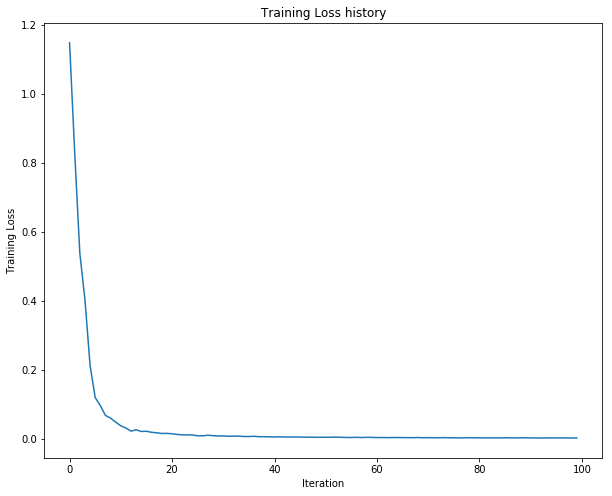

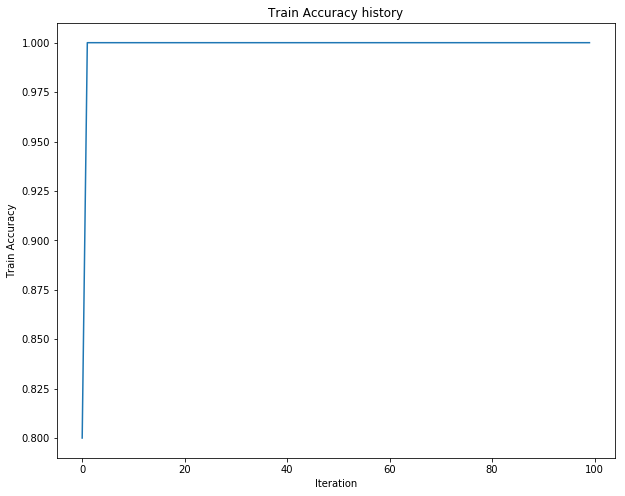

In [176]:
# from cs209b.neural_net import *
#from cs209b.optim import *
params = init_toy_model()

# Make my NN
layer_1 = layers.Linear(*params['W1'].T.shape,reg='frob',reg_param=5e-6,init_vals=(params['W1'].T,params['b1'].ravel()))
act_1 = layers.Relu()
layer_2 = layers.Linear(*params['W2'].T.shape,reg='frob',reg_param=5e-6,init_vals=(params['W2'].T,params['b2'].ravel()))
net_3 = nn.Network([layer_1,act_1,layer_2], ls.CrossEntropy(), optim.SGD(lr=1e-1))

costs,val_acc = net_3.pavlos_train(X,Y_enc,num_iterations=100,batch_size=100,val_sets =(X,Y_enc))
# net = train_2layer_net(params, X, Y_enc, X_val=X, Y_val=Y_enc,
#             learning_rate=1e-1, reg=5e-6,
#             num_iters=100, verbose=False)

print('Final training loss: ', costs[-1])

# plot the loss history
plt.plot(costs)
plt.xlabel('Iteration')
plt.ylabel('Training Loss')
plt.title('Training Loss history')
plt.show()

# plot the validation accuracy history
plt.plot(val_acc)
plt.xlabel('Iteration')
plt.ylabel('Train Accuracy')
plt.title('Train Accuracy history')
plt.show()

### Dropout

Dropout is a regularization technique for deep learning that randomly shuts down some neurons in each iteration. 

The idea is that at each iteration, you train a different version of the network that uses only a subset of your neurons. The network thus become less sensitive to the activation of specific groups of neurons, because they can be shut down at any time. This encourages weights to be spread among all values.

You will now modify the forward and backward pass of `loss_2layer_net` function to incorporate dropout on the input and hidden layer, from file __cs209b/neural_net.py__. We do not apply dropout to the output layer. We will implment inverted dropout, so that the `predict` function is transparent to the whole process.

In order to implement the regularization method, you have to generate a random matrix $D^{[0]}$ and $D^{[1]}$ with 1's and 0's with the same shape as the input and hidden feature $a^{[1]}$ indicating if the neuron is active or inactive. The probability of getting an active neuron is $1-p$, where $p$ referst to the dropout probability. Do not forget to normalize the output of every layer that uses dropout with $1/(1-p)$.

1. Implement the forward and backward pass now. 

Run the following code to check for correctness. You should see a plot with noisy descent and loss value around 0.52902613.

Final training loss:  0.52993136353


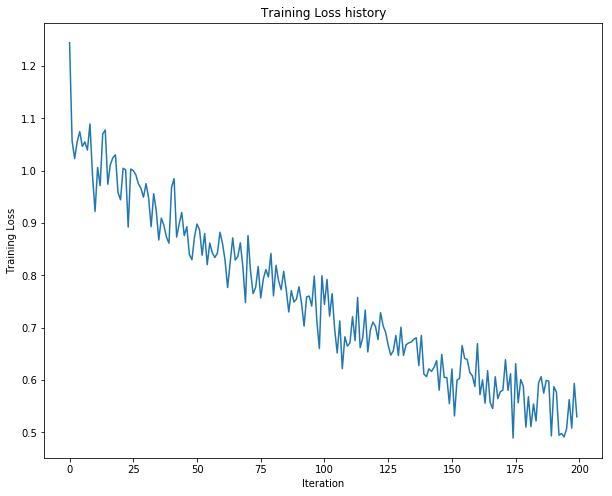

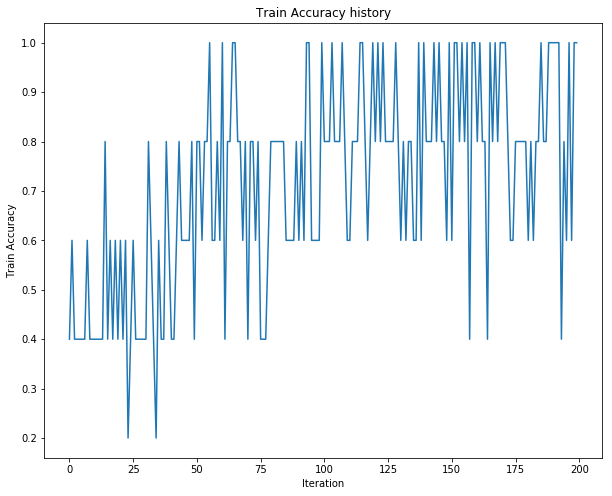

In [223]:
params = init_toy_model()
# Make my NN
layer_1 = layers.Linear(*params['W1'].T.shape,reg='frob',reg_param=0.0,dropout=0.4, \
                        init_vals=(params['W1'].T,params['b1'].ravel()))
act_1 = layers.Relu()
layer_2 = layers.Linear(*params['W2'].T.shape,reg='frob',reg_param=0.0, \
                        init_vals=(params['W2'].T,params['b2'].ravel()))
net_3 = nn.Network([layer_1,act_1,layer_2], ls.CrossEntropy(), optim.SGD(lr=.001162))

costs,val_acc = net_3.pavlos_train(X,Y_enc,num_iterations=200,batch_size=100,val_sets=(X,Y_enc))
# net = train_2layer_net(params, X, Y_enc, X_val=X, Y_val=Y_enc,
#             dropout=0.4, learning_rate=1e-2, reg=0.0,
#             num_iters=200, verbose=False)

print('Final training loss: ', costs[-1])

# plot the loss history
plt.plot(costs)
plt.xlabel('Iteration')
plt.ylabel('Training Loss')
plt.title('Training Loss history')
plt.show()

# plot the validation accuracy history
plt.plot(val_acc)
plt.xlabel('Iteration')
plt.ylabel('Train Accuracy')
plt.title('Train Accuracy history')
plt.show()


### Load the data
Now that you have implemented a two-layer network that passes gradient checks and works on toy data, it's time to load up our favorite CIFAR-10 data so we can use it to train a classifier on a real dataset.

In [42]:
from cs209b.data_utils import load_CIFAR10


def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the two-layer neural net classifier. These are the same steps as
    we used for the SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
        
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis=0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image

    # Reshape data to rows
    X_train = X_train.reshape(num_training, -1)
    X_val = X_val.reshape(num_validation, -1)
    X_test = X_test.reshape(num_test, -1)

    return X_train, y_train, X_val, y_val, X_test, y_test


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 3072)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3072)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3072)
Test labels shape:  (1000,)


Perform one-hot encoding for the training, validation and test labels:

In [43]:
Y_train_enc = encode_labels(y_train)
Y_val_enc = encode_labels(y_val)
Y_test_enc = encode_labels(y_test)

### Train a network
To train our network we will use SGD. In addition, we will adjust the learning rate with an exponential learning rate schedule as optimization proceeds; after each epoch, we will reduce the learning rate by multiplying it by a decay rate.

In [236]:
input_size = 32 * 32 * 3
hidden_size = 50
num_classes = 10
params = init_2layer_net(input_size, hidden_size, num_classes)

# Make my NN
layer_1 = layers.Linear(*params['W1'].T.shape,reg='frob',reg_param=0.25,dropout=0.0, \
                        init_vals=(params['W1'].T,params['b1'].ravel()))
act_1 = layers.Relu()
layer_2 = layers.Linear(*params['W2'].T.shape,reg='frob',reg_param=0.25, \
                        init_vals=(params['W2'].T,params['b2'].ravel()))
net_3 = nn.Network([layer_1,act_1,layer_2], ls.CrossEntropy(), optim.SGD(lr=1e-4,lr_decay=0.95))

# Train the network
costs,val_acc,tr_acc = net_3.pavlos_train(X_train,Y_train_enc,num_iterations=1000,batch_size=200,\
                                   val_sets=(X_val,Y_val_enc),verbose=True)

# Predict on the validation set
print('Validation accuracy: ', val_acc[-1])

cost at iteration 0: 2.3027668468693725
cost at iteration 100: 2.3023614558602716
cost at iteration 200: 2.296753075419335
cost at iteration 300: 2.260992241683602
cost at iteration 400: 2.1852087250248085
cost at iteration 500: 2.145050692446863
cost at iteration 600: 2.0530081550357977
cost at iteration 700: 2.063872959671171
cost at iteration 800: 2.0964581898350496
cost at iteration 900: 2.018028918357958
Validation accuracy:  0.268


### Debug the training
With the default parameters we provided above, you should get a validation accuracy of about 0.29 on the validation set. This isn't very good.

One strategy for getting insight into what's wrong is to plot the loss function and the accuracies on the training and validation sets during optimization.

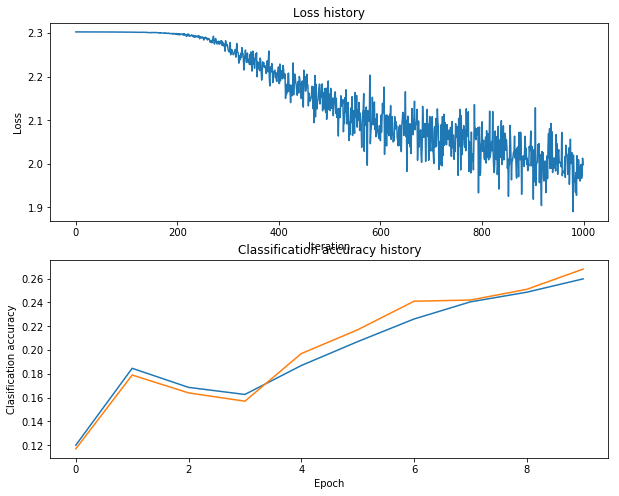

In [238]:
# Plot the loss function and train / validation accuracies
plt.subplot(2, 1, 1)
plt.plot(costs)
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(tr_acc, label='train')
plt.plot(val_acc, label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Clasification accuracy')
plt.show()

### Tune your hyperparameters

**Tuning**. Tuning the hyperparameters and developing intuition for how they affect the final performance is a large part of using Neural Networks. You should experiment with different values of the various hyperparameters, including hidden layer size, learning rate, numer of training epochs, regularization strength and dropout probability. You might also consider tuning the learning rate decay, but you should be able to get good performance using the default value.

1. Find good hyperparameters that achieve a classification accuracy of greater than 48% on the validation set. You may use the following code to search for these parameters. For grading purposes, leave only the best hyperparameters you found.

In [250]:
best_net = None # store the best model into this 

#################################################################################
# Tune hyperparameters using the validation set.                                #
# Store your best trained model leaving only your best combination of           #
# hyperparameters.                                                              #
#                                                                               #
# Use this code to find good hyperparamters.                                    # 
#################################################################################

best_val = -1
results = {}

np.random.seed(0)

batch_sizes = [200,400]      # KEEP ONLY THE BEST VALUE
learning_rates = [1e-3,1e-4]  # KEEP ONLY THE BEST VALUE
regs = [.05,0.0]              # KEEP ONLY THE BEST VALUE
dropouts = [0.0,0.2]         # KEEP ONLY THE BEST VALUE 

grid_search=[(s,x,y,z) for s in dropouts for x in batch_sizes for y in learning_rates for z in regs]

for dropout, batch_size,learning_rate,reg in grid_search:
    
    params = init_2layer_net(input_size, hidden_size, num_classes)

    # Define the network
    layer_1 = layers.Linear(*params['W1'].T.shape,reg='frob',reg_param=reg,dropout=dropout, \
                            init_vals=(params['W1'].T,params['b1'].ravel()))
    act_1 = layers.Relu()
    layer_2 = layers.Linear(*params['W2'].T.shape,reg='frob',reg_param=reg, \
                            init_vals=(params['W2'].T,params['b2'].ravel()))
    net = nn.Network([layer_1,act_1,layer_2], ls.CrossEntropy(), optim.SGD(lr=learning_rate,lr_decay=0.95))

    # Train the network
    costs,val_acc,tr_acc = net.pavlos_train(X_train,Y_train_enc,num_iterations=2000,batch_size=batch_size,\
                                   val_sets=(X_val,Y_val_enc),verbose=False)

    # Predict on the validation set and compute accuracy
    print('Validation accuracy: ', val_acc[-1])
    
    results[(batch_size,learning_rate,reg)]=val_acc[-1]
    
    if val_acc[-1]>best_val:
        best_val=val_acc[-1]
        best_net=net

Validation accuracy:  0.497
Validation accuracy:  0.495
Validation accuracy:  0.327
Validation accuracy:  0.319
Validation accuracy:  0.504
Validation accuracy:  0.504
Validation accuracy:  0.322
Validation accuracy:  0.325
Validation accuracy:  0.437
Validation accuracy:  0.45
Validation accuracy:  0.332
Validation accuracy:  0.337
Validation accuracy:  0.443
Validation accuracy:  0.448
Validation accuracy:  0.323
Validation accuracy:  0.322


### Run on the test set
When you are done experimenting, you should evaluate your final trained network on the test set; you should get above 48%.

In [251]:
test_acc = util.accuracy(best_net, X_test, y_test)
print('Test accuracy: ', test_acc)

Test accuracy:  0.486


## OPTIONAL: Optimization algorithms (3 extra points)

You have used stochastic gradient descent to train the network, but now we are going to implement sgd with momentum, RMSprop and Adam as optimization improvements to our training.

### SGD with momentum

SGD has trouble minimizing the cost on areas where the surface curves more steeply in one dimension than in another. In these situations, SGD oscillates across the slopes and only making slow progress along the bottom towards a local optimum. 

SGD with Momentum helps accelerate SGD in the relevant direction and dampens oscillations. It adds a fraction $\gamma$ of the update vector of the past time step to the current update vector:
\begin{align}
    & v_t = \beta v_{t-1} + (1-\beta) \nabla_{w} J \\
    & w_t = w_{t-1} - \alpha v_t,
\end{align}
where $w$ is the parameter of interest, $\alpha$ refers to the learning rate, and $t$ iteration number.
The previous update rule is performed on all parameters of the neural network, i.e., $W^{[1]}$, $W^{[2]}$, $b^{[1]}$ and $b^{[2]}$. The velocity $v_t$ is different for each parameter.

1. Implement function `sgd_momentum` in __cs209b/optim.py__ and run the following code to minimize the cost function. You should get an accuracy of around 0.47 or above in 2000 iterations with a learning rate of 1e-3. 

cost at iteration 0: 2.302777555180451
cost at iteration 100: 2.107718498705637
cost at iteration 200: 1.892552969256035
cost at iteration 300: 1.614710656524596
cost at iteration 400: 1.859453356272057
cost at iteration 500: 1.7197647572723307
cost at iteration 600: 1.5911903527884732
cost at iteration 700: 1.6672967319514036
cost at iteration 800: 1.2440333818300924
cost at iteration 900: 1.358571336130532
cost at iteration 1000: 1.5821511960244288
cost at iteration 1100: 1.4653177433000861
cost at iteration 1200: 1.5640742875784297
cost at iteration 1300: 1.582113644037643
cost at iteration 1400: 1.5576109349247402
cost at iteration 1500: 1.244255592542298
cost at iteration 1600: 1.3645223939989675
cost at iteration 1700: 1.4348478143565844
cost at iteration 1800: 1.4043410856131897
cost at iteration 1900: 1.4683669683566207
Validation accuracy:  0.475


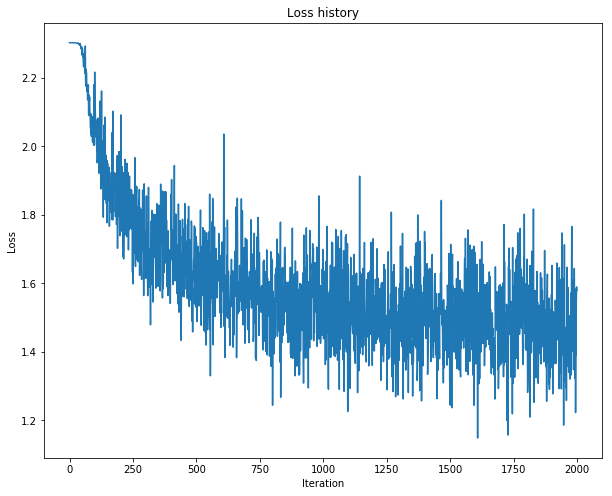

In [255]:
input_size = 32 * 32 * 3
hidden_size = 50
num_classes = 10
params = init_2layer_net(input_size, hidden_size, num_classes)
# Define the network
layer_1 = layers.Linear(*params['W1'].T.shape,reg='frob',reg_param=0.25,dropout=0.0, \
                        init_vals=(params['W1'].T,params['b1'].ravel()))
act_1 = layers.Relu()
layer_2 = layers.Linear(*params['W2'].T.shape,reg='frob',reg_param=0.25, \
                        init_vals=(params['W2'].T,params['b2'].ravel()))
net_m = nn.Network([layer_1,act_1,layer_2], ls.CrossEntropy(), optim.SGD(lr=1e-3,beta=0.9))

# Train the network
costs,val_acc,tr_acc = net_m.pavlos_train(X_train,Y_train_enc,num_iterations=2000,batch_size=100,\
                               val_sets=(X_val,Y_val_enc),verbose=True)

# net = train_2layer_net(params, X_train, Y_train_enc, X_val, Y_val_enc,
#             num_iters=2000, batch_size=100, optimizer="momentum",
#             learning_rate=1e-3, beta = 0.9, learning_rate_decay=1,
#             reg=0.25, verbose=True)

plt.plot(costs)
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')

# Predict on the validation set
print('Validation accuracy: ', val_acc[-1])

### RMSprop

RMSprop is an unpublished, adaptive learning rate method proposed by Geoff Hinton to resolve the diminishing learning rates of Adagrad and other descent techniques. It tracks a second moment of the gradient to control the learning rate. Its equations are as follows:
\begin{align}
    & s_t = \beta_2 s_{t-1} + (1-\beta_2) (\nabla_w J)^2 \\
    & w_t = w_{t-1} + \alpha \frac{1}{\sqrt{s_t}+\epsilon} \nabla_w J,
\end{align}
for every parameter to update. 

1. Implement function `rmsprop` on file __cs209b/optim.py__. We get an accuracy of 0.47.

In [263]:
input_size = 32 * 32 * 3
hidden_size = 50
num_classes = 10
params = init_2layer_net(input_size, hidden_size, num_classes)
# Define the network
layer_1 = layers.Linear(*params['W1'].T.shape,reg='frob',reg_param=0.25,dropout=0.0, \
                        init_vals=(params['W1'].T,params['b1'].ravel()))
act_1 = layers.Relu()
layer_2 = layers.Linear(*params['W2'].T.shape,reg='frob',reg_param=0.25, \
                        init_vals=(params['W2'].T,params['b2'].ravel()))
net_m = nn.Network([layer_1,act_1,layer_2], ls.CrossEntropy(), optim.RMSProp(lr=1e-4,beta=0.999,eps=1e-8))

# Train the network
costs,val_acc,tr_acc = net_m.pavlos_train(X_train,Y_train_enc,num_iterations=2000,batch_size=200,\
                               val_sets=(X_val,Y_val_enc),verbose=True)

# Predict on the validation set
print('Validation accuracy: ', val_acc[-1])

cost at iteration 0: 2.3027702407074213
cost at iteration 100: 1.7125613170219423
cost at iteration 200: 1.6919611123013811
cost at iteration 300: 1.6758856815374015
cost at iteration 400: 1.5906214345077794
cost at iteration 500: 1.5082057358243721
cost at iteration 600: 1.6630698659438417
cost at iteration 700: 1.6267370194651694
cost at iteration 800: 1.6409799051503202
cost at iteration 900: 1.626838455701022
cost at iteration 1000: 1.58337091188925
cost at iteration 1100: 1.556090126346315
cost at iteration 1200: 1.7006873203891697
cost at iteration 1300: 1.7834457348180985
cost at iteration 1400: 1.4958568856601724
cost at iteration 1500: 1.5403224457260423
cost at iteration 1600: 1.4074399162724087
cost at iteration 1700: 1.6252090601969353
cost at iteration 1800: 1.4912697543044298
cost at iteration 1900: 1.540759542457426
Validation accuracy:  0.492


### Adam

Adaptive Moment Estimation ([Adam](https://arxiv.org/abs/1412.6980)) is first order method that that computes adaptive learning rates for each parameter.

Adam keeps an exponentially decaying average of past gradients $v_t$, similar to momentum:
\begin{align}
    & v_t = \beta_1 v_{t-1} + (1-\beta_1) \nabla_w J \\
    & s_t = \beta_2 s_{t-1} + (1-\beta_2) (\nabla_w J)^2.
\end{align}

$v_t$ and $s_t$ are estimates of the first moment (the mean) and the second moment (the uncentered variance) of the gradients, respectively. As $v_t$ and $s_t$ are initialized, the authors of Adam observe that they are biased towards zero, especially during the initial time steps, and especially when the decay rates are small (i.e. $\beta_1$ and $\beta_2$ are close to 1).

They control these underestimates with bias correction:
\begin{align}
    & \hat{v}_t = \frac{v_t}{1 - \beta_1^t} \\
    & \hat{s}_t = \frac{s_t}{1 - \beta_2^t},
\end{align}
where $\hat{v}_t$ and $\hat{s}_t$ stand for the corrected versions.

Finally, the authors update the parameters with the following rule:
\begin{equation}
    w_t = w_{t-1} - \alpha \frac{\hat{v}_t}{\sqrt{\hat{s}_t}+\epsilon}.
\end{equation}

1. Implement function `adam` in __cs209b/optim.py__ and run the following code to minimize the cost function. We get an accuracy of 0.48 in 2000 iterations with a learning rate of 1e-4.

In [264]:
input_size = 32 * 32 * 3
hidden_size = 50
num_classes = 10
params = init_2layer_net(input_size, hidden_size, num_classes)
# Define the network
layer_1 = layers.Linear(*params['W1'].T.shape,reg='frob',reg_param=0.25,dropout=0.0, \
                        init_vals=(params['W1'].T,params['b1'].ravel()))
act_1 = layers.Relu()
layer_2 = layers.Linear(*params['W2'].T.shape,reg='frob',reg_param=0.25, \
                        init_vals=(params['W2'].T,params['b2'].ravel()))
net_m = nn.Network([layer_1,act_1,layer_2], ls.CrossEntropy(), optim.Adam(lr=1e-4,beta1=0.9,\
                                                                             beta2=0.999,eps=1e-8))

# Train the network
costs,val_acc,tr_acc = net_m.pavlos_train(X_train,Y_train_enc,num_iterations=2000,batch_size=200,\
                               val_sets=(X_val,Y_val_enc),verbose=True)


# Predict on the validation set
print('Validation accuracy: ', val_acc[-1])

cost at iteration 0: 2.3027639105899165
cost at iteration 100: 1.7073167562780573
cost at iteration 200: 1.6856646669917787
cost at iteration 300: 1.5946404409257842
cost at iteration 400: 1.613120170586815
cost at iteration 500: 1.5564844165109841
cost at iteration 600: 1.5659624327702288
cost at iteration 700: 1.6412452678432405
cost at iteration 800: 1.5275419592401496
cost at iteration 900: 1.4402713389453337
cost at iteration 1000: 1.4634863379031156
cost at iteration 1100: 1.57588473017564
cost at iteration 1200: 1.4854754511801276
cost at iteration 1300: 1.447151024995628
cost at iteration 1400: 1.472761124874442
cost at iteration 1500: 1.5105421009728395
cost at iteration 1600: 1.5214898481744215
cost at iteration 1700: 1.5644070890480213
cost at iteration 1800: 1.554950778381675
cost at iteration 1900: 1.3640292236285494
Validation accuracy:  0.486


---
### Acknowledgments for the CS209B part:

Some of the code snipets and documentation was borrowed from the cs231n Standford course. In particular, we reused all code to download CIFAR-10 and data_utils.py. Our problem layout is also based on their original structure, inspired as well on deeplearning.ai course layout.

### Just for fun:

Here I train a naive 5 layer network just to show how my framework works. 

loss at epoch 0: 33.16940247733244
loss at epoch 10: 6.373615488004316
loss at epoch 20: 3.624397506408804
loss at epoch 30: 2.858323727071508
loss at epoch 40: 2.5429376533678365
loss at epoch 50: 2.29119788948927
loss at epoch 60: 2.22533564807261
loss at epoch 70: 1.9046029021450177
loss at epoch 80: 1.9560626297735217
loss at epoch 90: 1.8304845820118105


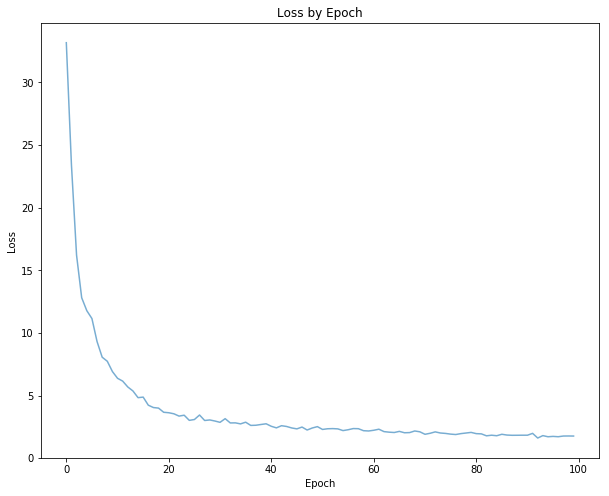

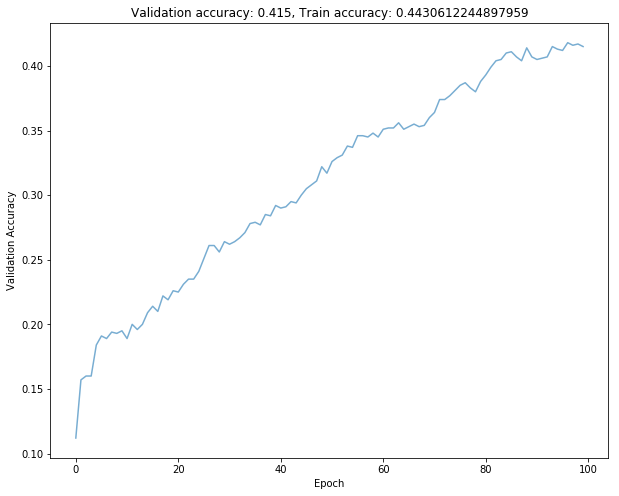

In [52]:
np.random.seed(0)
std_t = 1e-1
input_size = 32 * 32 * 3
hidden_size = 50
num_classes = 10

# initials 
W1_t = (std_t * np.random.randn(hidden_size,input_size)).T
b1_t = np.zeros(hidden_size)
Wm_t = (std_t * np.random.randn(hidden_size,hidden_size)).T
bm_t = np.zeros(hidden_size)
Wo_t = (std_t * np.random.randn(num_classes,hidden_size)).T
bo_t = np.zeros(num_classes)

# Define the network
layer_1 = layers.Linear(input_size, hidden_size,reg='l2',reg_param=0.05,init_vals=(W1_t,b1_t))
act_1 = layers.Relu()
layer_2 = layers.Linear(hidden_size, hidden_size,reg='l2',reg_param=0.05,init_vals=(Wm_t,bm_t))
act_2 = layers.Relu()
layer_3 = layers.Linear(hidden_size, hidden_size,reg='frob',reg_param=0.0,init_vals=(Wm_t,bm_t))
act_3 = layers.Relu()
layer_4 = layers.Linear(hidden_size, num_classes,reg='frob',reg_param=0.0,init_vals=(Wo_t,bo_t))

all_layers = [layer_1,act_1,layer_2,act_2,layer_3,act_3,layer_4]
net_m = nn.Network(all_layers, ls.CrossEntropy(), optim.Adam(lr=1e-5,beta1=0.9,beta2=0.99,eps=1e-8))

# Train the network
costs,val_acc = net_m.train(X_train,Y_train_enc,epochs=100,batch_size=200,\
                                   val_sets=(X_val,Y_val_enc),verbose=True)
# Plot loss
plt.plot(costs,alpha=0.6)
plt.title('Loss by Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Plot 
plt.plot(val_acc,alpha=0.6)
plt.title(f'Validation accuracy: {val_acc[-1]}, Train accuracy: {util.accuracy(net_m,X_train,Y_train_enc,True)}')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.show()

### The deeper model may be cool, but it does not perform very well.

The reasons for this can vary.  First, we have added a lot of complexity to the model without much regularization (I didn't have the time to try more models).  Also, deep Vanilla NN's have not been shown to perform very well on image data like we are dealing with.  The network would perform much better if it had convolutional layers (again, I didn't have time to add conv layers to my framework). It also does not have intelligent initial conditions, with a model of this size can be an issue with limited training time. 